# Analysis of Outliers

In [2]:
import numpy as np
import pandas as pd
from scipy import stats

import itertools
import copy
import re

import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

import seaborn as sns

-----------

In [423]:
#df = pd.read_csv('processed_data.csv')

CAR_df = pd.read_csv('post_plots_CAR.csv')
CAR_df.rename(columns={'CloseOut':'Close_out'}, inplace=True) 

CAR_df = CAR_df.drop(['Unnamed: 0'], axis = 1)
CAR_df = CAR_df[CAR_df.Close_out <= 200]
CAR_df = CAR_df[CAR_df.Close_out > 25]


--------

In [424]:
CAR_df.TA.unique()

array(['Oncology', 'GI', 'NS', 'NonCore', 'RGH'], dtype=object)

In [425]:
CAR_df.head()

,TrialID,Phase,TA,CRO,Close_out
0,C16014 Korea Continuation,III,Oncology,PPD,51
1,C34007,I,Oncology,IQVIA,100
2,TAK-438_302,III,GI,IQVIA,112
3,TAK-438_304,III,GI,IQVIA,146
4,TAK-935-1005,I,NS,PPD,63


In [426]:
def get_aggregated_df(df, isCore):
    '''
    Takes general dataframe as input and return an aggregated df, with the prevalence data
    '''    
    # Providing labels for the grouping and the new columns after resetting the index
    GROUP_COLS = ['Phase', 'TA','CRO']
    NEW_COL_NAMES = ['Phase', 'TA', 'CRO', 'OutlierCounts', 'TotObs']
    
#     # Difference between TA and GeneralTA is that GeneralTA is mapped -> CHANGE NAME TO MAPPED TA
#     if isCore:
#         GROUP_COLS.append('TA')
#     elif not isCore:
#         GROUP_COLS.append('TA')
    
    CORE_TAU = ['Oncology', 'GI', 'NS', 'RGH', 'NonCore']
    NON_CORE_TAU = ['PDT', 'OPHTH', 'CVM', 'Vaccine', 'Others']
    
    if not isCore:        
        df = df[df.TA.isin(NON_CORE_TAU)]
     
    new_df = df.groupby(by=GROUP_COLS).agg({'isOutlier':'sum','TrialID':'count'}).reset_index()
    new_df.columns = NEW_COL_NAMES
    
    new_df['Prevalence'] = round(new_df.OutlierCounts/new_df.TotObs,2)
    new_df = new_df[new_df.Phase != '0']

    return new_df

In [427]:
def get_plot_order(category, isCore):
    '''
    Takes as input the category (CRO, Phase, TA) being analysed and returns the category's order
    in the plot
    '''
    
    CRO_order = ['IQVIA', 'PRA', 'PPD', 'Celerion','Other']
    CORE_ORDER = ['Oncology', 'GI', 'NS', 'RGH', 'NonCore']
    NON_CORE_ORDER = ['PDT', 'CVM', 'Vaccine', 'OPHTH', 'Others']
    
    if category == 'TA': 
        if isCore:
            plot_order = CORE_ORDER
        elif not isCore:
            plot_order = NON_CORE_ORDER
    elif category == 'CRO':
        plot_order = CRO_order
    else: 
        plot_order = None
    
    return plot_order

def get_hue_name(c,isGeneric):
    '''
    Returns the hue value for the specific plots
    '''
    if isGeneric or c=='CRO':
        return None
    elif not isGeneric:
        return 'CRO'


def get_generic_plot_df(df, c):
    '''
    Takes as input the original dataframe, and generalizes the group to the desired
    category, c. Returns the grouped dataframe to be used in the plot.
    '''
    df = df.groupby(by=[c]).sum().reset_index()
    df.Prevalence = round(df.OutlierCounts/df.TotObs,2)
    
    return df


def get_non_generic_plot_df(df,c):
    '''
    Takes in the original dataframe and performs a groupby for
    a specific category to ensure the outlier counts are correct
    '''
    if c=='CRO':
        plot_df = df
    else:
        plot_df = df.groupby(by=['CRO', c]).sum().reset_index()
        plot_df.Prevalence = round(plot_df.OutlierCounts/plot_df.TotObs,2) 

    return plot_df


In [428]:
def generate_plots(df, isCore, isGeneric):
    '''
    Splitting the generation of the plots themselves
    '''    
    if isCore:
        print('Plots for assets in core TAU')
    elif not isCore:
        print('Plots for assets not in core TAUs')
    
    yvals = ['Prevalence']#['OutlierCounts', 'Prevalence', 'TotObs'] #changed TotObs to OutlierCounts
    
    sns.set_palette('cool')
    
    # Plots for Phase and TA
    categories = ['Phase', 'TA', 'CRO']
    for yval in yvals: 
        if yval == 'OutlierCounts':
            y_label = '# of Outliers'
        elif yval == 'TotObs':
            y_label = '# of Trials'
        else:
            y_label = yval
            
        for c in categories:
            # Groups by to ensure correct ratios are obtained
            if isGeneric or c =='CRO':
                plot_df = get_generic_plot_df(df,c)
            elif not isGeneric:
                plot_df = get_non_generic_plot_df(df,c)
            
            plot_order = get_plot_order(c,isCore)
            hue_name = get_hue_name(c, isGeneric)
            print(f'Counting trials for {c}...')
            print(df.loc[:, c].value_counts())
            
            plt.figure(figsize = (10,8))
            ax = sns.barplot(x = c, y = yval, data = plot_df, hue = hue_name, ci = None, order = plot_order)
            plt.xticks(fontsize = 15)
            plt.yticks(fontsize = 15)
            ax.set(ylim=(0, 0.5))
            ax.set_xlabel(c, fontsize = 15)
            ax.set_ylabel(y_label, fontsize = 15)
            if yval != 'Prevalence':
                ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            
            plt.savefig(f'CAR_{MODE}_{days}_days_{yval}_{c}_isGeneric_{isGeneric}.png')
    
    pass

In [429]:
def label_outliers(df, MODE, days):
    '''
    Returns a df with a column labelling the outliers. Here, an outlier is defined in 
    accordance with the MODE and days used. I.e. MODE = 'more than' and days = 50, 
    will have an outlier trial as one whose Close_out took over 50 days
    '''
    df['isOutlier'] = 0
    
    if MODE == 'greater than':
        df.loc[df.Close_out > days, ['isOutlier']] = 1
    elif MODE == 'less than':
        df.loc[df.Close_out <= days, ['isOutlier']] = 1
    
    return df

In [430]:
def get_prevalence_plots(df, MODE, days, isCore, isGeneric):
    '''
    Given a dataframe with outlier counts, compute the prevalance 
    and distributon of outliers across CRO, TA, and Phase
    '''
    print(f'Outliers considered as trials with a close-out time {MODE} {days} days')
    
    # Generating a df with a column labelling outliers
    df = label_outliers(df, MODE, days)
    
    # Obtaining a new, aggregated dataframe 
    new_df = get_aggregated_df(df,isCore)
    
    totTrials = df.shape[0]
    totOutliers = new_df.OutlierCounts.sum()
    percOutliers = round(100*totOutliers/totTrials,2)
    
    print(f'{percOutliers}% of trials ({totOutliers} out of {totTrials}) with a close-out time {MODE} {days} days')
    
    if isCore:
        ### Plots for CORE_TA assets ###    
        generate_plots(new_df, isCore, isGeneric)
    elif not isCore:
        ### Plots for NON_CORE_TA assets ###
        generate_plots(new_df, isCore, isGeneric)
    
    return new_df

-----

In [431]:
def outlier_analysis(df, MODE, days, isCore, isGeneric):
    '''
    Combines all the previous functions to simplify whether the 
    outlier analysis will be for trials that took more or less than a certain amount of days
    
    df = process dataframe 
    MODE = either 'less than' or 'more than' (corresponds to <= or >)
    days = # of days to use as delimiter 
    
    isCore = bool (True = analysis for CORE TAU, False = analysis for Non-CORE TAU)
    isGeneric = bool (True = not breaking down analysis by CRO, False = breaks down analysis by CRO)
    
    Function will return the aggregated df used to make the plots
    ''' 
    new_df = get_prevalence_plots(df, MODE, days, isCore, isGeneric)
    
    return new_df 

In [432]:
MODE = 'less than'
days = 33

In [433]:
CAR_df.Phase.value_counts()

I      103
III     70
II      61
IV      11
Name: Phase, dtype: int64

In [434]:
CAR_df.TA.value_counts()

Oncology    82
GI          60
NonCore     43
NS          43
RGH         17
Name: TA, dtype: int64

In [435]:
CAR_df.CRO.value_counts()

IQVIA       65
Other       62
PPD         57
PRA         43
Celerion    18
Name: CRO, dtype: int64

Outliers considered as trials with a close-out time less than 33 days
10.26% of trials (24 out of 234) with a close-out time less than 33 days
Plots for assets in core TAU
Counting trials for Phase...
I      21
III    16
II     15
IV      6
Name: Phase, dtype: int64
Counting trials for TA...
Oncology    14
NonCore     12
NS          12
GI          11
RGH          9
Name: TA, dtype: int64
Counting trials for CRO...
IQVIA       18
PPD         14
Other       14
PRA          8
Celerion     4
Name: CRO, dtype: int64


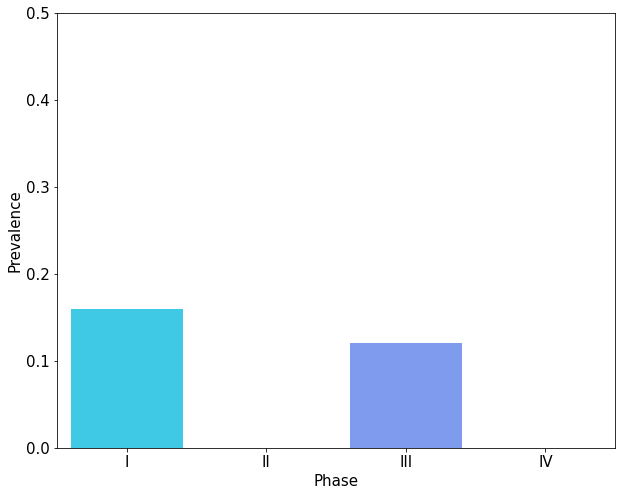

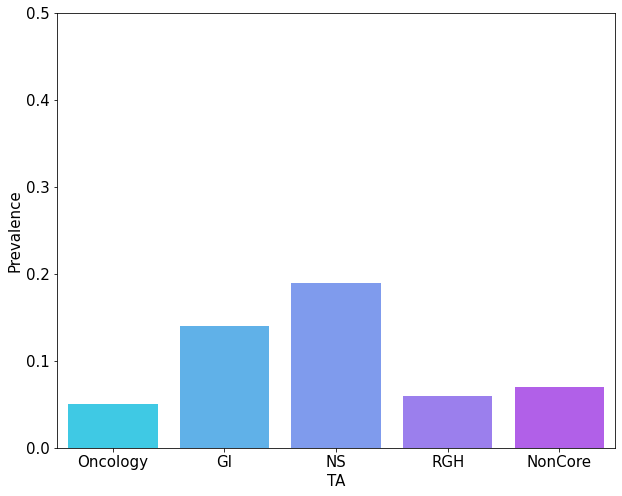

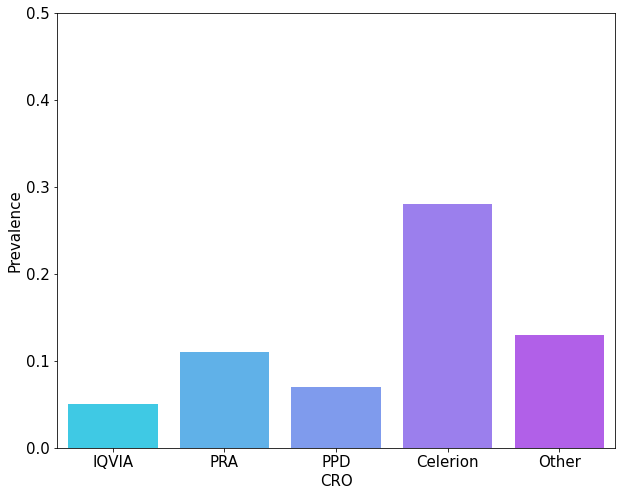

In [149]:
new_df = outlier_analysis(CAR_df, MODE, days, isCore=True, isGeneric=True)

### Creating the stacked barchart 

- Requirements
    - Stacked horizontal
    - Colour by type of class not category 
    - Categories: top, bottom, middle quartiles 
    - Plots by CRO, Phase, and TA

In [436]:
temp_df = copy.deepcopy(CAR_df)

In [437]:
temp_df['TopQuartile'] = 0
temp_df['BottomQuartile'] = 0
temp_df['MidQuartile'] = 0

In [438]:
top_quartile_bound = 33
bot_quartile_bound = 82

In [439]:
temp_df.loc[temp_df.Close_out < top_quartile_bound, 'TopQuartile'] = 1
temp_df.loc[(temp_df.Close_out >= top_quartile_bound)&(temp_df.Close_out <= bot_quartile_bound), 'MidQuartile'] = 1
temp_df.loc[temp_df.Close_out > bot_quartile_bound, 'BottomQuartile'] = 1

In [440]:
def get_row_order(label_order):
    '''
    Takes in the order of the labels for a group and returns the priority index
    to be used for future sorting
    '''
    
    label_dict = dict()
    
    i = 1
    for label in label_order:
        label_dict[label] = i
        i += 1
    
    return label_dict

def get_priority(label_dict, group, label):
    '''
    Given an order of priorities, return the priority for the given label
    '''
    priority = label_dict[label]
    return priority 

def order_df(df, group, label_dict):
    '''
    Takes in median_df and returns ordered df in accordance with the desired label order
    '''
    df['Priority'] = df.loc[:, group]
    df.loc[:, 'Priority'] = df.loc[:, 'Priority'].apply(lambda x: get_priority(label_dict, group, label = x)) 
    df = df.sort_values(by ='Priority')
    
    return df


def get_agg_df(df, group, label_order):
    
    agg_df = df.groupby(by =[group]).agg({'TopQuartile': 'sum', 
                                          'MidQuartile': 'sum',
                                          'BottomQuartile': 'sum', 
                                          'TrialID': 'count'}).reset_index()

    agg_df.loc[:, 'TopQuartile'] = agg_df.loc[:, 'TopQuartile']/agg_df.TrialID
    agg_df.loc[:, 'MidQuartile'] = agg_df.loc[:, 'MidQuartile']/agg_df.TrialID
    agg_df.loc[:, 'BottomQuartile'] = agg_df.loc[:, 'BottomQuartile']/agg_df.TrialID
    
    label_dict = get_row_order(label_order)
    agg_df = order_df(agg_df, group, label_dict)
    
    
    return agg_df

In [445]:
def get_quartiles(df, horizontal):
    '''
    Provides the quartile values, in accordance with whether horizontal or vertical stacked plots are desired
    '''
    
    if horizontal:
        TopQ = df.loc[:, 'TopQuartile'][::-1]
        MidQ = df.loc[:, 'MidQuartile'][::-1]
        BottomQ = df.loc[:, 'BottomQuartile'][::-1]
    
    elif not horizontal:
        TopQ = df.loc[:, 'TopQuartile']
        MidQ = df.loc[:, 'MidQuartile']
        BottomQ = df.loc[:, 'BottomQuartile']
    
    
    return TopQ, MidQ, BottomQ


def generate_plots(names, r, TopQ, MidQ, BottomQ, horizontal):
    
    sns.set(font_scale=1)
    sns.set_style('ticks')
    sns.set_palette('cool')

    
    if horizontal:

        plt.barh(names, TopQ, color='#b5ffb9', edgecolor='white', label = 'Top Quartile')
        plt.barh(names, MidQ, left=TopQ, color='#f9bc86', edgecolor='white', label = 'Interquartile')
        plt.barh(names, BottomQ, left=MidQ+TopQ, color='#a3acff', edgecolor='white', label = 'Bottom Quartile')
        plt.yticks(r, names)
        plt.ylabel(f'{group}')
        plt.xlabel('Percentage')
    
    elif not horizontal:
            
        barWidth = 0.85
        
        plt.bar(r, TopQ, color='#b5ffb9', edgecolor='white', width=barWidth, label = 'Top Quartile')
        plt.bar(r, MidQ, bottom=TopQ, color='#f9bc86', edgecolor='white', width=barWidth, label = 'Interquartile')
        plt.bar(r, BottomQ, bottom=[i+j for i,j in zip(TopQ, MidQ)], 
                color='#a3acff', edgecolor='white', width=barWidth, label = 'Bottom Quartile')

        plt.xticks(r, names)
        plt.xlabel(f'{group}')
        plt.ylabel('Percentage')
    
    plt.legend(loc='best', bbox_to_anchor=(1,1), ncol=1)
    
    pass

In [446]:
def stacked_plot(df, group, label_order, horizontal):
    '''
    Aggregates the values needed to generate the stacked plot 
    Outputs a horizontal or vertical stacked plot
    '''
    r = [i for i in range(df.shape[0])][::-1]
    names = label_order
    
    TopQ, MidQ, BottomQ = get_quartiles(df, horizontal)
    
    plt.figure(figsize = (10,8))
    generate_plots(names, r, TopQ, MidQ, BottomQ, horizontal)

    pass

In [447]:
groups = ['CRO', 'TA', 'Phase']

label_orders = [['IQVIA', 'PPD', 'PRA', 'Celerion', 'Other'],
                ['Oncology', 'GI', 'NS', 'RGH', 'NonCore'],
                ['I', 'II', 'III', 'IV']]


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


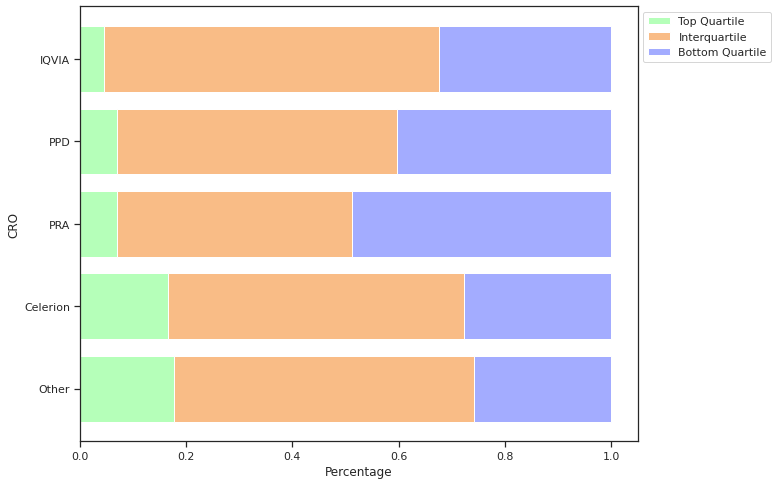

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


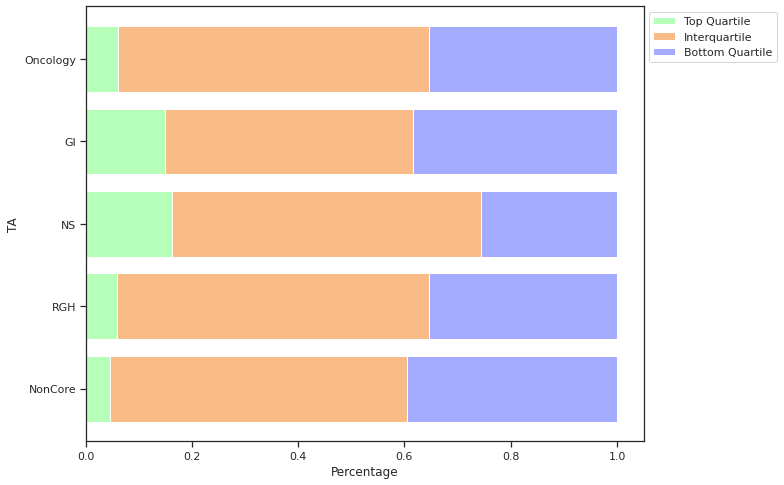

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


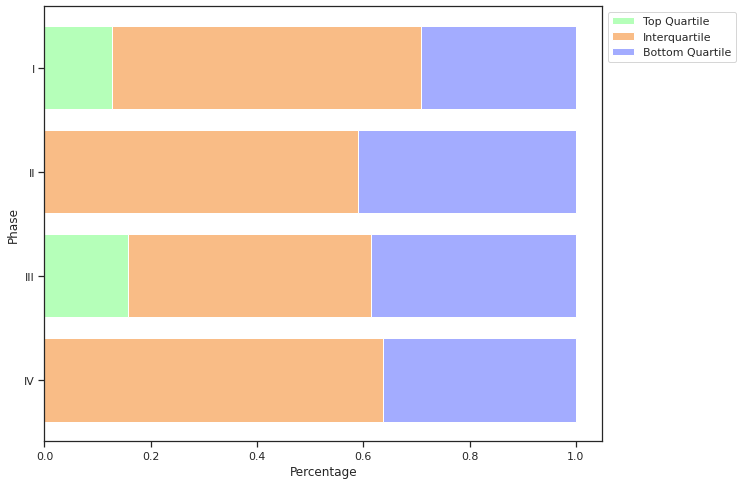

In [450]:
i = 0


for group in groups:
    label_order = label_orders[i]
    group = groups[i]
    agg_df = get_agg_df(temp_df, group, label_order)
    stacked_plot(agg_df, group, label_order, horizontal = True)
    plt.savefig(f'{group}_quartiles.eps', bbox_inches = 'tight')
    plt.show()
    i+=1
    

--------

### BACK UP 

In [ ]:
def get_rate(df2, outlier_thresh):
    df2['isOutlier'] = 0
    df2.loc[df2.Close_out > outlier_thresh, ['isOutlier']] = 1
    return df2.isOutlier.sum()/df2.shape[0]


# Rate of outliers as a function of threshold value
plt.plot([i for i in range(0,151,10)], [get_rate(df2,i) for i in range(0,151,10)], color = 'red')

# Get this same plot, but add hues for Phase and CRO, for TA --> CHECK with Takeda if there are particular 
# phases they're interested in 

In [ ]:
# Getting plots by each category
def get_outliers_category(df, INPUT_COL, isCore):
    '''
    Will plot the percentage of outliers by category. Takes input of processed df with outliers labeled 
    and desired category, returns a plot that tells you the prevalence of outliers. 
    I.e. "10% of IQVIA observations are outliers"
    '''
        
    distributions = {'Item': [], 'OutlierCount': [], 'TotObservations':[], 'Prevalence':[]}

    COL_MAP = {'Phase': 'GeneralPhase', 'CRO': 'GeneralCRO', 'CORE_TA': 'GeneralTA', 'NON_CORE_TA': 'TA'}

    
    label_order = {'Phase': ['I', 'II', 'III', 'IV'], 
                   'CRO':['IQVIA', 'PRA', 'PPD', 'Celerion', 'Other']}
    
    if isCore:
        label_order['CORE_TA'] = ['GI', 'Oncology', 'CNS', 'RGH', 'NonCore'] 
    elif not isCore:
        label_order['NON_CORE_TA'] = ['PDT', 'OPHTH', 'CVM', 'Vaccine', 'Others']

    COL_NAME = COL_MAP[INPUT_COL]
    name_list = label_order[INPUT_COL]

    prevalence_list = list()

    for name in name_list:
        # Calculating values
        outlier_counts = df[df.loc[:,COL_NAME] == name].isOutlier.sum()
        tot_obs = df[df.loc[:,COL_NAME] == name].shape[0]
        prevalence = round(outlier_counts/tot_obs, 2)
        
        # Adding info to dictionary 
        distributions['Item'].append(name)
        distributions['OutlierCount'].append(outlier_counts)
        distributions['TotObservations'].append(tot_obs)
        distributions['Prevalence'].append(prevalence)
        obs = distributions['TotObservations']
        

    # Plots "10% of IQVIA obs are outliers, 5% of PRA obs are outliers, etc."
    plt.figure(figsize = (10,6))
    ax = sns.barplot(x = distributions['Item'], 
                     y = distributions['Prevalence'], 
                     color = 'red')
    
    ax.set_xlabel(COL_NAME)
    ax.set_ylabel('Prevalence')
    ax.set_title(f'% of outliers per {INPUT_COL} category')
    
    
    return distributions

In [ ]:
COLS = ['Phase', 'CRO', 'CORE_TA', 'NON_CORE_TA']
distributions_dict = dict()

for INPUT_COL in COLS:   
    distributions_dict[INPUT_COL] = get_outliers_category(grouped_df, INPUT_COL)

In [ ]:
def country_outlier_breakdown(outlier_data):
    '''
    Takes in a subset dataset a returns a ranked list of countries 
    ranked by frequency of occurrence in the outlier set
    '''
    
    # Calculating the set of countries used in the trial 

    # Loop finds all countries in all trials (will include repeated names)
    country_meta_ls = outlier_data.Country
    agg_country_ls = list()
    for country_ls in country_meta_ls:
        if ',' in country_ls:
            temp_ls = country_ls.split(',')
            agg_country_ls.extend(temp_ls)
        else:
            agg_country_ls.append(country_ls)

    # Loop returns the unique list of countries, with typos (such as whitespaces) fixed 
    temp_ls = list()
    for country in agg_country_ls:
        if country[0] == ' ':
            country = country[1:]
            temp_ls.append(country)
        else:
            temp_ls.append(country)
    country_ls = list(set(temp_ls))
    country_ls.sort()
    
    
    # Assigning a frequency of use and average close_out time per country
    country_dict = dict() 

    # Iterate through each row so that you count the number of times a country is selected, and finds the close out of the 
    # trial 

    country_idx = outlier_data.columns.get_loc('Country')
    close_out_idx = outlier_data.columns.get_loc('Close_out')

    # Loop returns the a dictionary with the specified structure above
    for country in country_ls:
        country_dict[country] = [0,[]]
        for row in outlier_data.values:
            trial_countries = row[country_idx]
            trial_close_out = row[close_out_idx]
            if country in trial_countries:
                country_dict[country][0] += 1
                country_dict[country][1].append(trial_close_out)
    
    # Visualising how many times each country is used in a trial
    country_names = list(country_dict.keys())
    vals = country_dict.values()

    # Frequency of appearance in trial
    country_freq = list()
    country_close_out = list()
    for val in vals:
        country_freq.append(val[0])
        country_close_out.append(val[1])

    country_freq_df = pd.DataFrame({'Country':country_names, 'Frequency': country_freq, 'CloseOut': country_close_out})
    country_rank = country_freq_df.sort_values('Frequency', ascending = False)
    
    occurrences = country_rank.Frequency.sum()

    country_rank['Weight'] = country_rank.Frequency.apply(lambda x: round(100*x/occurrences,2))
    country_rank.Country = country_rank.Country.apply(lambda x: change_country_name(x))
    
    return country_rank